In [43]:
import sys
import os

# Add the parent directory of 'station_focus' to sys.path
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Parent directory
sys.path.append(base_path)
file_path = os.path.join(base_path, "data/boston/bike_trip_focused_data.parquet")

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from src import data_processing as dp
from src import utils
import geopandas as gpd

import seaborn as sns
from sklearn.ensemble import IsolationForest

from datetime import datetime
from DIFFI.utils import *


In [2]:
# dp.bike_trip_process_data_and_save(city_name = 'boston', start = datetime(2023, 1, 1), end = datetime(2023, 1, 31), pca=False)

In [3]:
station_data = dp.from_trip_to_station_focused(file_path)

In [4]:
station_data.columns

Index(['station_id', 'hour', 'day', 'month', 'is_start', 'count',
       'tripduration_mean', 'tripduration_std', 'tripduration_median',
       'distance_mean', 'distance_std', 'distance_median', 'speed_mean',
       'speed_std', 'speed_median', 'user_type_encoded_mean', 'temp_mean',
       'prcp_mean', 'wspd_mean', 'coco_mean', 'station_name', 'neighborhood',
       'geometry', 'nearby_transit_stops', 'dayofweek', 'is_weekend',
       'special_day'],
      dtype='object')

# Temporal Analysis


The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.



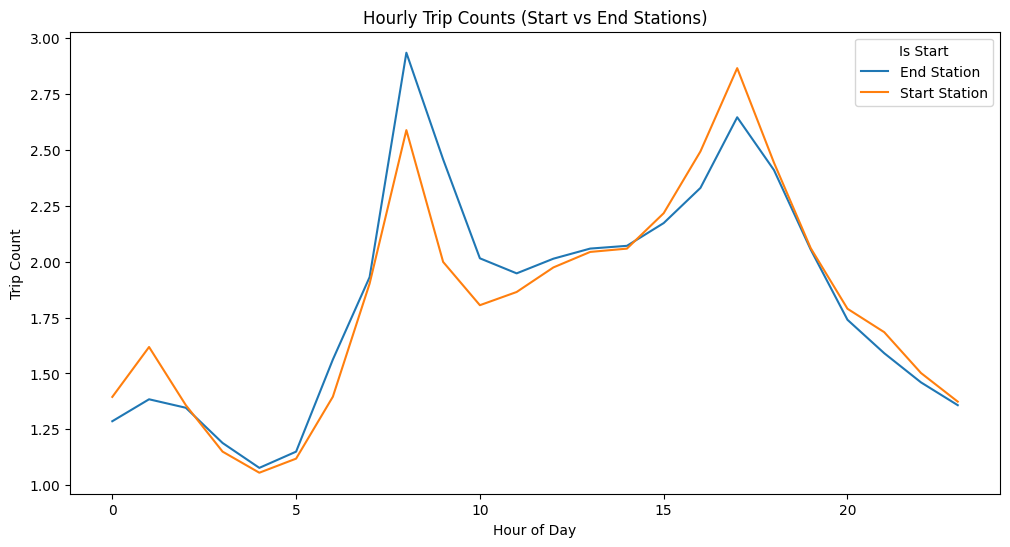

In [34]:
# Hourly analysis of trip counts
plt.figure(figsize=(12, 6))
sns.lineplot(data=station_data, x='hour', y='count', hue='is_start', ci=None)
plt.title('Hourly Trip Counts (Start vs End Stations)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
plt.legend(title="Is Start", labels=["End Station", "Start Station"])
plt.show()


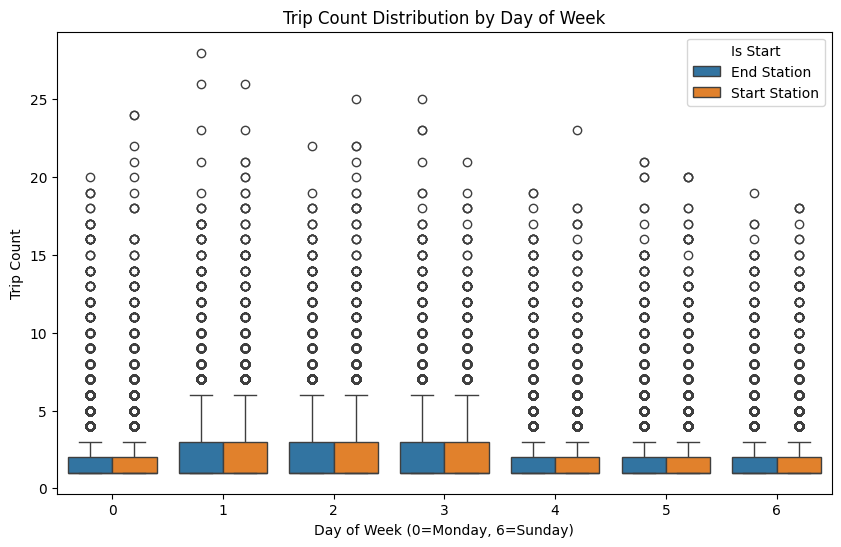

In [35]:
# Day-of-week analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=station_data, x='dayofweek', y='count', hue='is_start')
plt.title('Trip Count Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Trip Count')
# Get the handles and labels from the plot
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


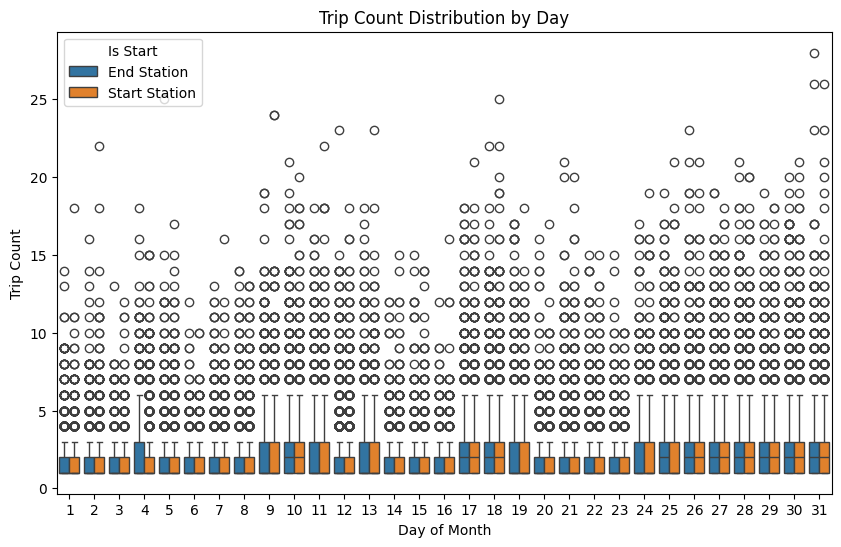

In [36]:
# Day-of-week analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=station_data, x='day', y='count', hue='is_start')
plt.title('Trip Count Distribution by Day')
plt.xlabel('Day of Month')
plt.ylabel('Trip Count')
# Get the handles and labels from the plot
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


# Station-Specific Analysis

Top 10 Stations by Total Trip Count:
station_name
MIT at Mass Ave / Amherst St                   6807
Central Square at Mass Ave / Essex St          6160
MIT Vassar St                                  3977
Harvard Square at Mass Ave/ Dunster            3926
MIT Pacific St at Purrington St                3896
Forsyth St at Huntington Ave                   3339
Boylston St at Massachusetts Ave               3105
MIT Stata Center at Vassar St / Main St        3038
Charles Circle - Charles St at Cambridge St    2858
Mass Ave at Albany St                          2840
Name: count, dtype: int64

Bottom 10 Stations by Total Trip Count:
station_name
Community Life Center         1
Auburndale                    3
Cleary Sq                     3
Goodhue St at Grove St        3
Newton Library                4
Ross Playground               4
Blue Hill Ave at Almont St    5
Hyde Park Library             6
Langley Lot                   6
Beacon at Walnut              7
Name: count, dtype: int64


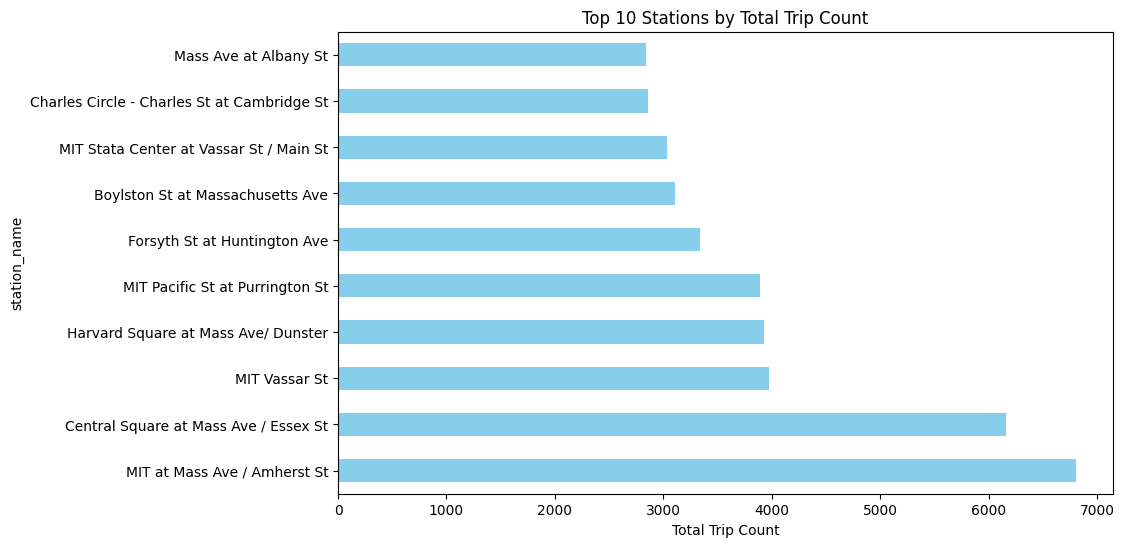

In [37]:
# Total counts by station
top_stations = station_data.groupby('station_name')['count'].sum().nlargest(10)
bottom_stations = station_data.groupby('station_name')['count'].sum().nsmallest(10)

print("Top 10 Stations by Total Trip Count:")
print(top_stations)

print("\nBottom 10 Stations by Total Trip Count:")
print(bottom_stations)

# Visualize top stations
top_stations.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Top 10 Stations by Total Trip Count')
plt.xlabel('Total Trip Count')
plt.show()


# Weather Impact

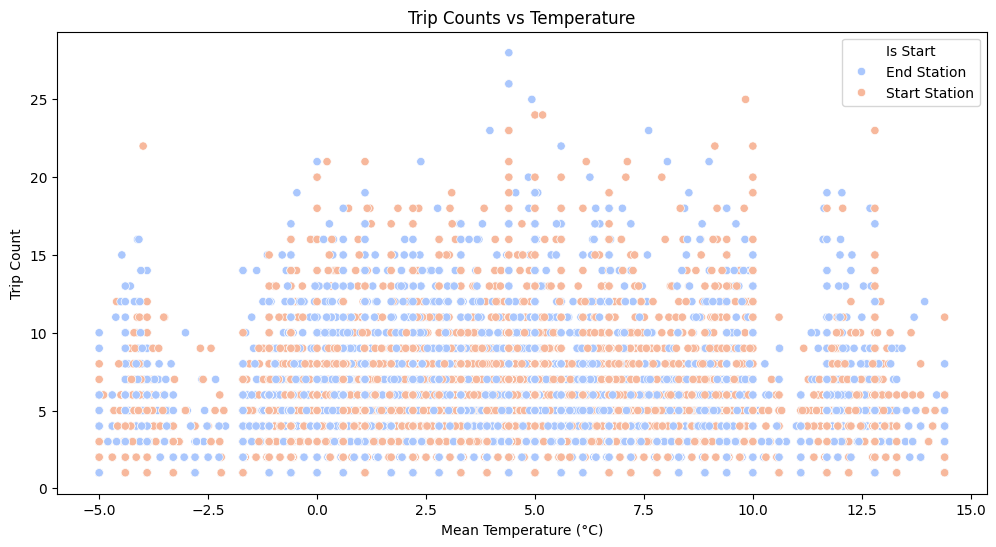

In [38]:
# Relationship between temperature and trip counts
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=station_data, x='temp_mean', y='count', hue='is_start', palette='coolwarm')
plt.title('Trip Counts vs Temperature')
plt.xlabel('Mean Temperature (°C)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


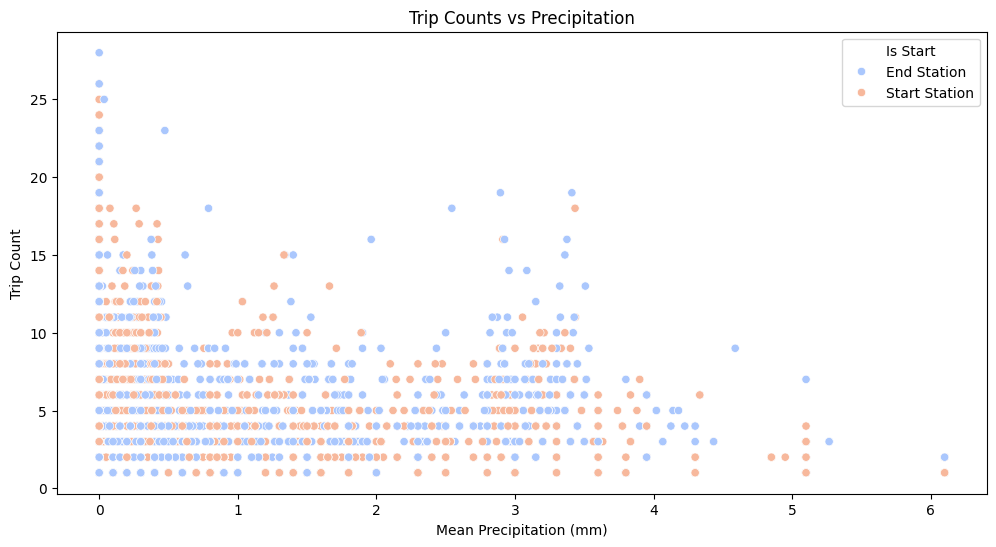

In [39]:
# Precipitation vs trip counts
plt.figure(figsize=(12, 6))
ax = sns.scatterplot(data=station_data, x='prcp_mean', y='count', hue='is_start', palette='coolwarm')
plt.title('Trip Counts vs Precipitation')
plt.xlabel('Mean Precipitation (mm)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Is Start", labels=["End Station", "Start Station"])
plt.show()


# Anomaly Analysis

In [4]:
# Select relevant features
features = [
    'count',                 # Core usage metric
    'distance_mean',         # Average trip distance
    'tripduration_mean',     # Average trip duration
    'speed_mean',            # Average trip speed
    'temp_mean',             # Weather impact
    'prcp_mean',             # Weather impact
    'wspd_mean',             # Weather impact
    'hour',                  # Temporal variation
    'day',
    'dayofweek',             # Temporal variation
    'nearby_transit_stops',   # Station context
    'user_type_encoded_mean',
    'coco_mean',             
    'is_weekend',
    'neighborhood',
    'is_start'
]
# features = ['station_id', 'hour', 'day', 'month', 'is_start', 'count',
#        'tripduration_mean', 'tripduration_std', 'tripduration_median',
#        'distance_mean', 'distance_std', 'distance_median', 'speed_mean',
#        'speed_std', 'speed_median', 'user_type_encoded_mean', 'temp_mean',
#        'prcp_mean', 'wspd_mean', 'coco_mean', 'station_name', 'neighborhood',
#        'geometry', 'nearby_transit_stops', 'dayofweek', 'is_weekend',
#        'special_day']
anomaly_data = station_data[features].fillna(0)

# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
station_data['anomaly'] = iso_forest.fit_predict(anomaly_data)

# Analyze anomalies
anomalies = station_data[station_data['anomaly'] == -1]
print("Anomalies Detected:")
print(anomalies)


Anomalies Detected:
        station_id  hour  day  month  is_start  count  tripduration_mean  \
20               1    20   30      1         0      1       61813.000000   
24               3     0   30      1         1      1        3643.000000   
45               3     7    1      1         0      1        7353.000000   
324              3    16   28      1         1      3        5382.666667   
479              4     1    1      1         1      4        1659.000000   
...            ...   ...  ...    ...       ...    ...                ...   
134104         590    20   13      1         1      1       40716.000000   
134139         590    23   15      1         1      1         179.000000   
134167         591     2   15      1         0      1        2123.000000   
134187         591     8    5      1         0      1       76048.000000   
134269         591    11    4      1         1      1       76048.000000   

        tripduration_std  tripduration_median  distance_mean  ...  

## Pair Plot (Multi-Dimensional View)

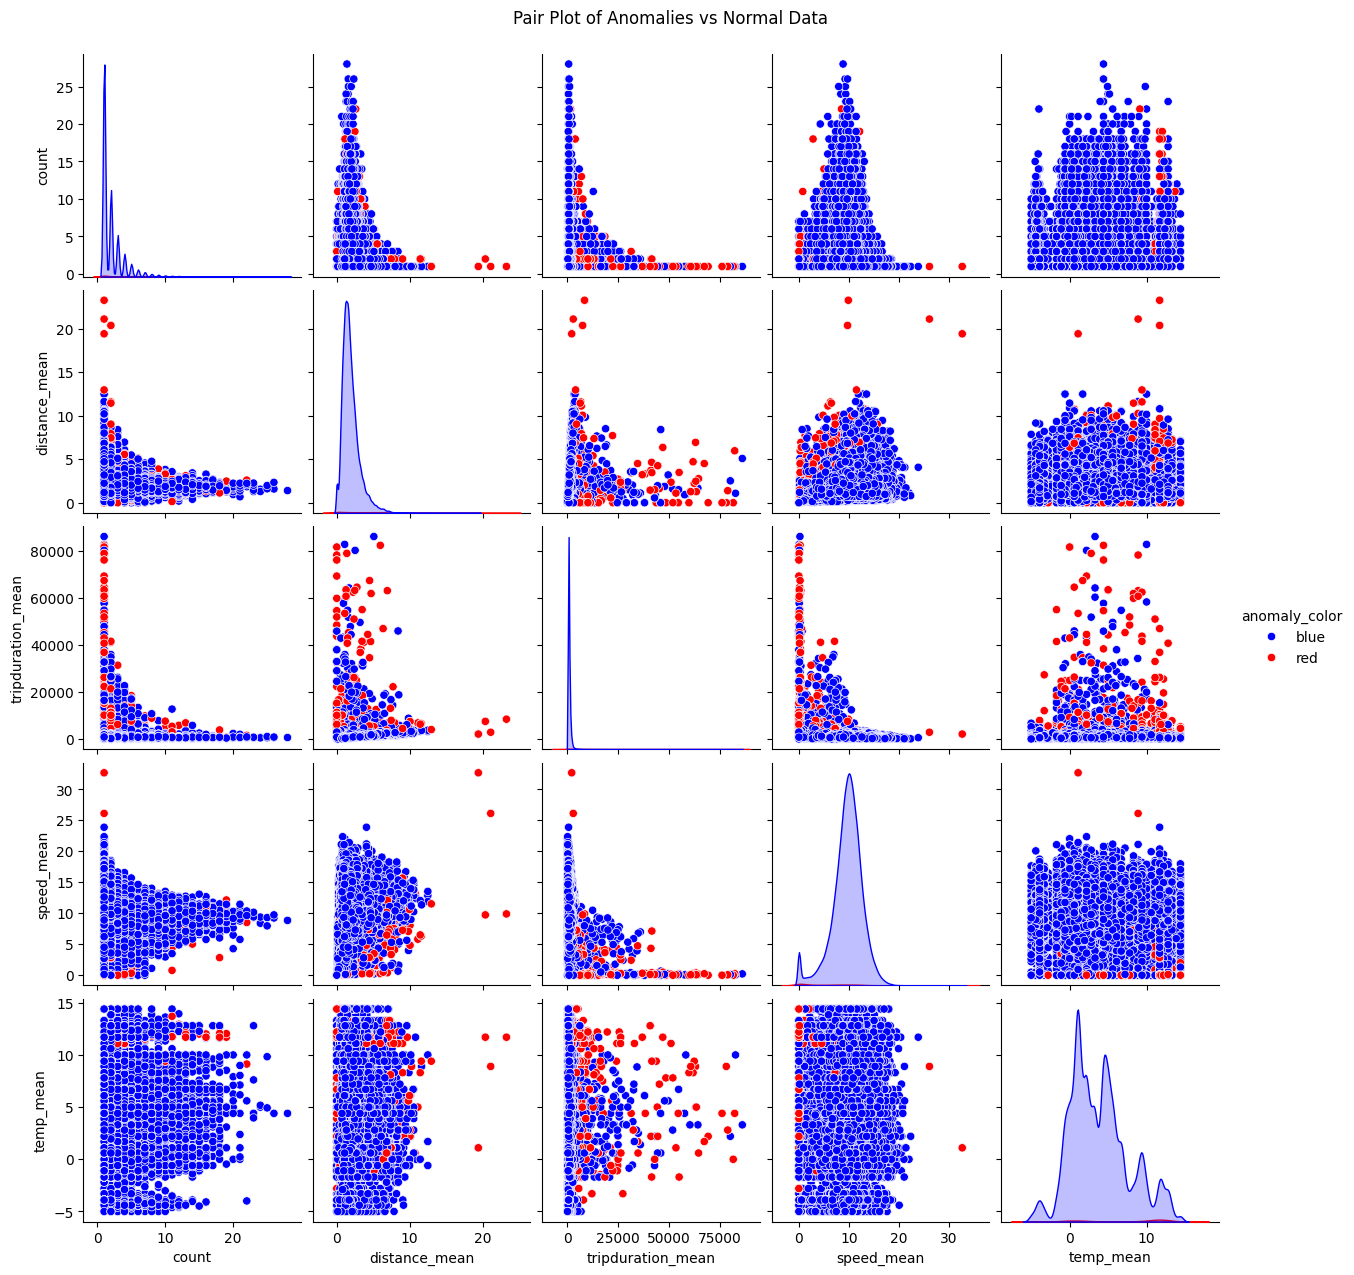

In [13]:
# Subset the data for pair plot visualization
features_for_pairplot = ['count', 'distance_mean', 'tripduration_mean', 'speed_mean', 'temp_mean']
station_data['anomaly_color'] = station_data['anomaly'].map({1: 'blue', -1: 'red'})

# Create pair plot with anomalies highlighted
sns.pairplot(station_data[features_for_pairplot + ['anomaly_color']], 
             hue='anomaly_color', palette={'blue': 'blue', 'red': 'red'})
plt.suptitle('Pair Plot of Anomalies vs Normal Data', y=1.02)
plt.show()

## Feature Distribution with Anomalies Highlighted

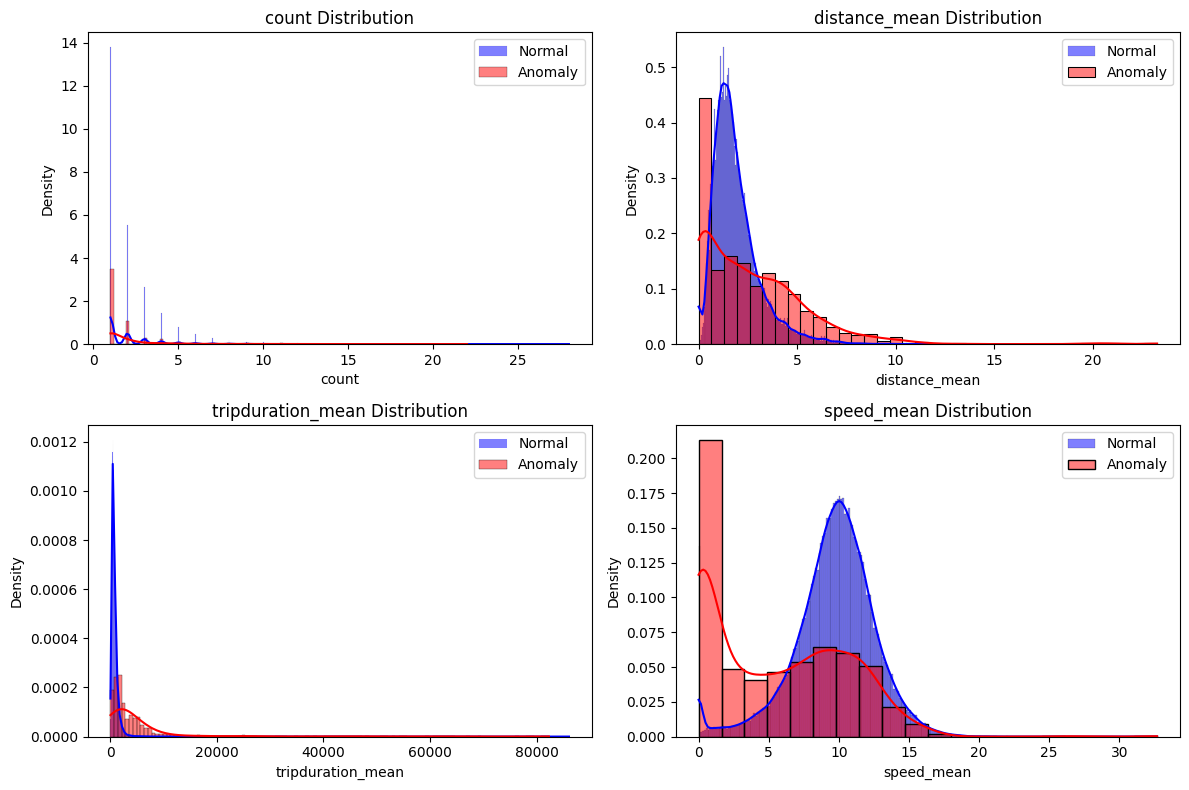

In [42]:
# Features to plot
features = ['count', 'distance_mean', 'tripduration_mean', 'speed_mean']

# Plot histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(station_data[station_data['anomaly'] == 1][feature], color='blue', label='Normal', kde=True, stat='density', ax=axes[i])
    sns.histplot(station_data[station_data['anomaly'] == -1][feature], color='red', label='Anomaly', kde=True, stat='density', ax=axes[i])
    axes[i].set_title(f'{feature} Distribution')
    axes[i].legend()

plt.tight_layout()
plt.show()

## Outlier Detection for Features

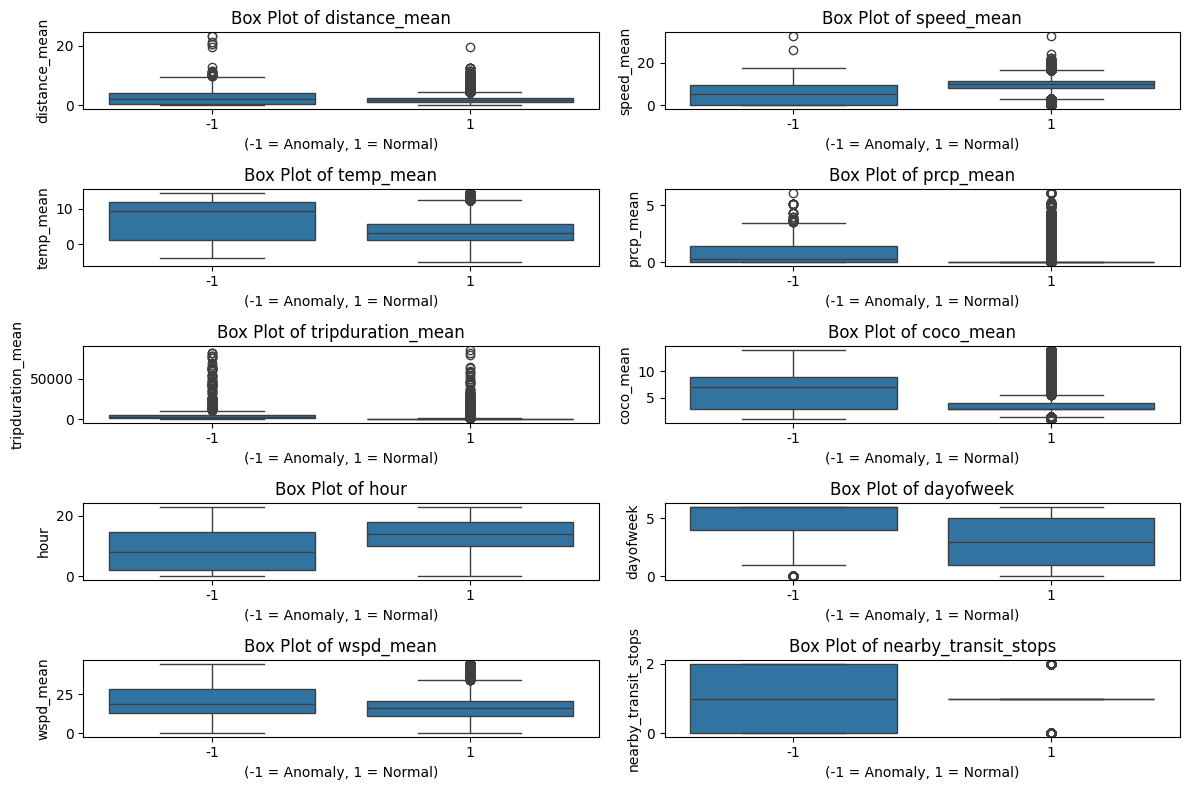

In [31]:
# Features to analyze
features = ['distance_mean', 'speed_mean', 'temp_mean', 
            'prcp_mean', 'tripduration_mean', 'coco_mean', 
            'hour', 'dayofweek', 'wspd_mean', 'nearby_transit_stops']

# Box plots for normal data and anomalies
fig, axes = plt.subplots(5, 2, figsize=(12, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(data=station_data, x='anomaly', y=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_xlabel('(-1 = Anomaly, 1 = Normal)')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()


## Temporal Analysis (Line Plots Over Time)

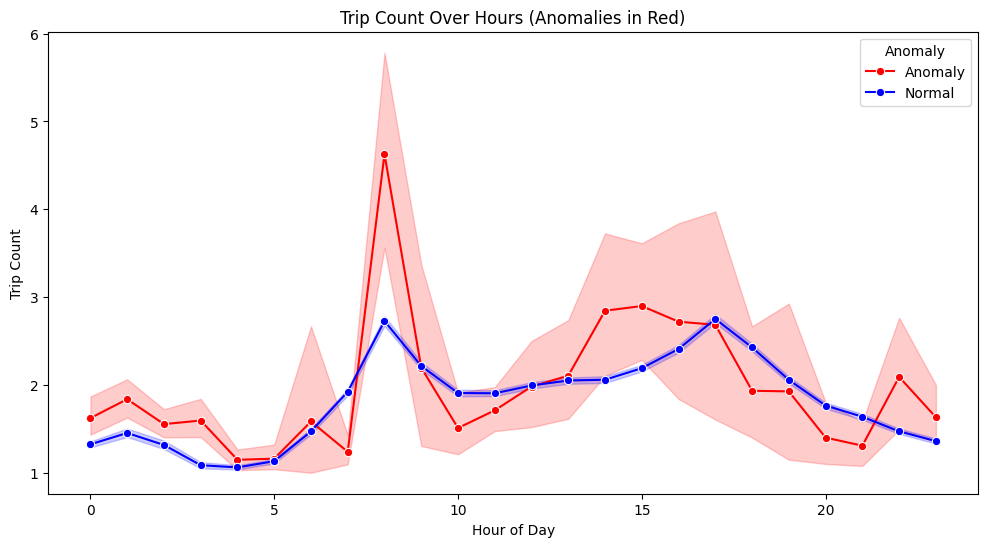

In [5]:
# Temporal visualization: Hour vs Trip Count
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=station_data, x='hour', y='count', hue='anomaly', 
             palette={1: 'blue', -1: 'red'}, marker='o')
plt.title('Trip Count Over Hours (Anomalies in Red)')
plt.xlabel('Hour of Day')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Anomaly", labels=["Anomaly", "Normal"])
plt.show()


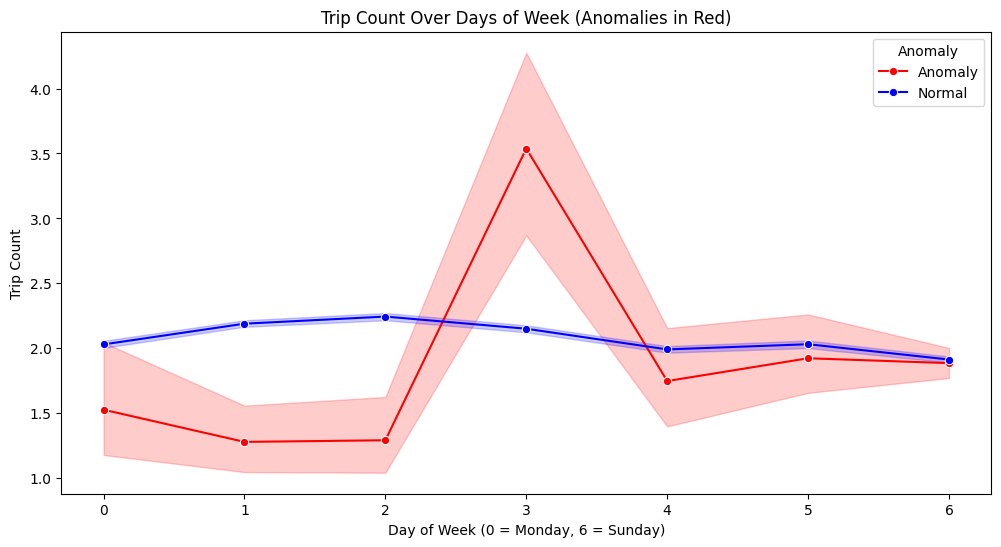

In [45]:
# Temporal Line Plot by Day of Week
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=station_data, x='dayofweek', y='count', hue='anomaly',
             palette={1: 'blue', -1: 'red'}, marker='o')
plt.title('Trip Count Over Days of Week (Anomalies in Red)')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles, title="Anomaly", labels=["Anomaly", "Normal"])
plt.show()

### Analysis of the spikes


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

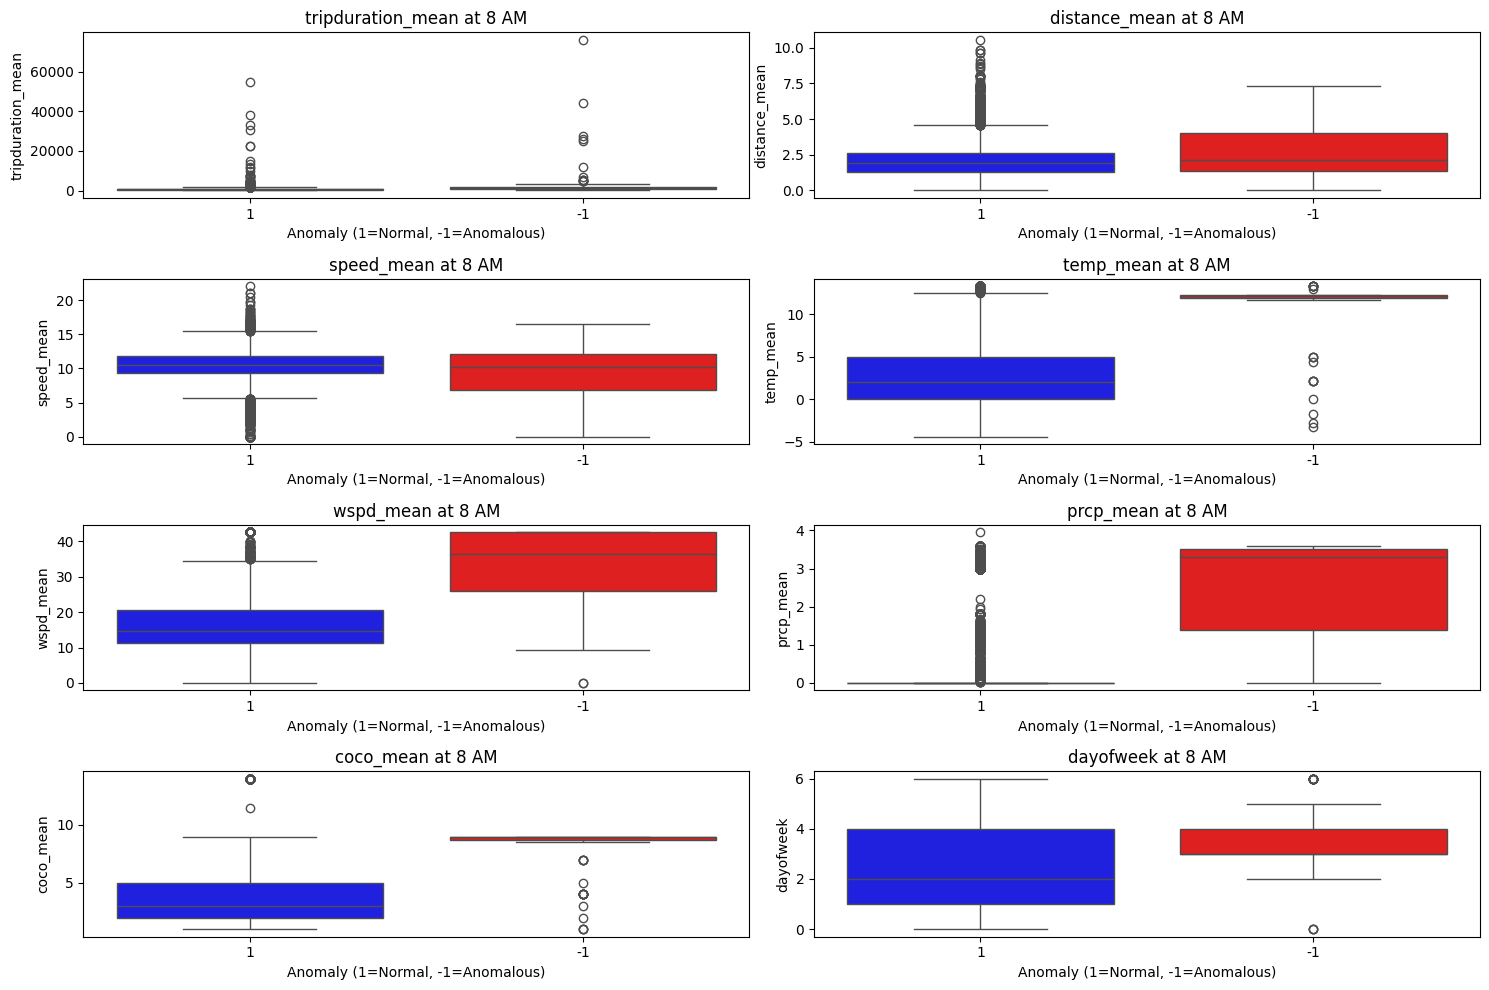

In [15]:
# Step 1: Filter trips that occurred at 8 AM
station_data_8am = station_data[station_data['hour'] == 8].copy()

# Convert anomaly column to string for visualization
station_data_8am['anomaly'] = station_data_8am['anomaly'].astype(str)

# Step 2: Define key numerical features for analysis
key_features = [
    'tripduration_mean', 'distance_mean', 'speed_mean',
    'temp_mean', 'wspd_mean', 'prcp_mean', 
    'coco_mean', 'dayofweek'
]

# Step 3: Create box plots
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(data=station_data_8am, x='anomaly', y=feature, palette={"1": "blue", "-1": "red"}, ax=axes[i])
    axes[i].set_title(f"{feature} at 8 AM")
    axes[i].set_xlabel("Anomaly (1=Normal, -1=Anomalous)")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

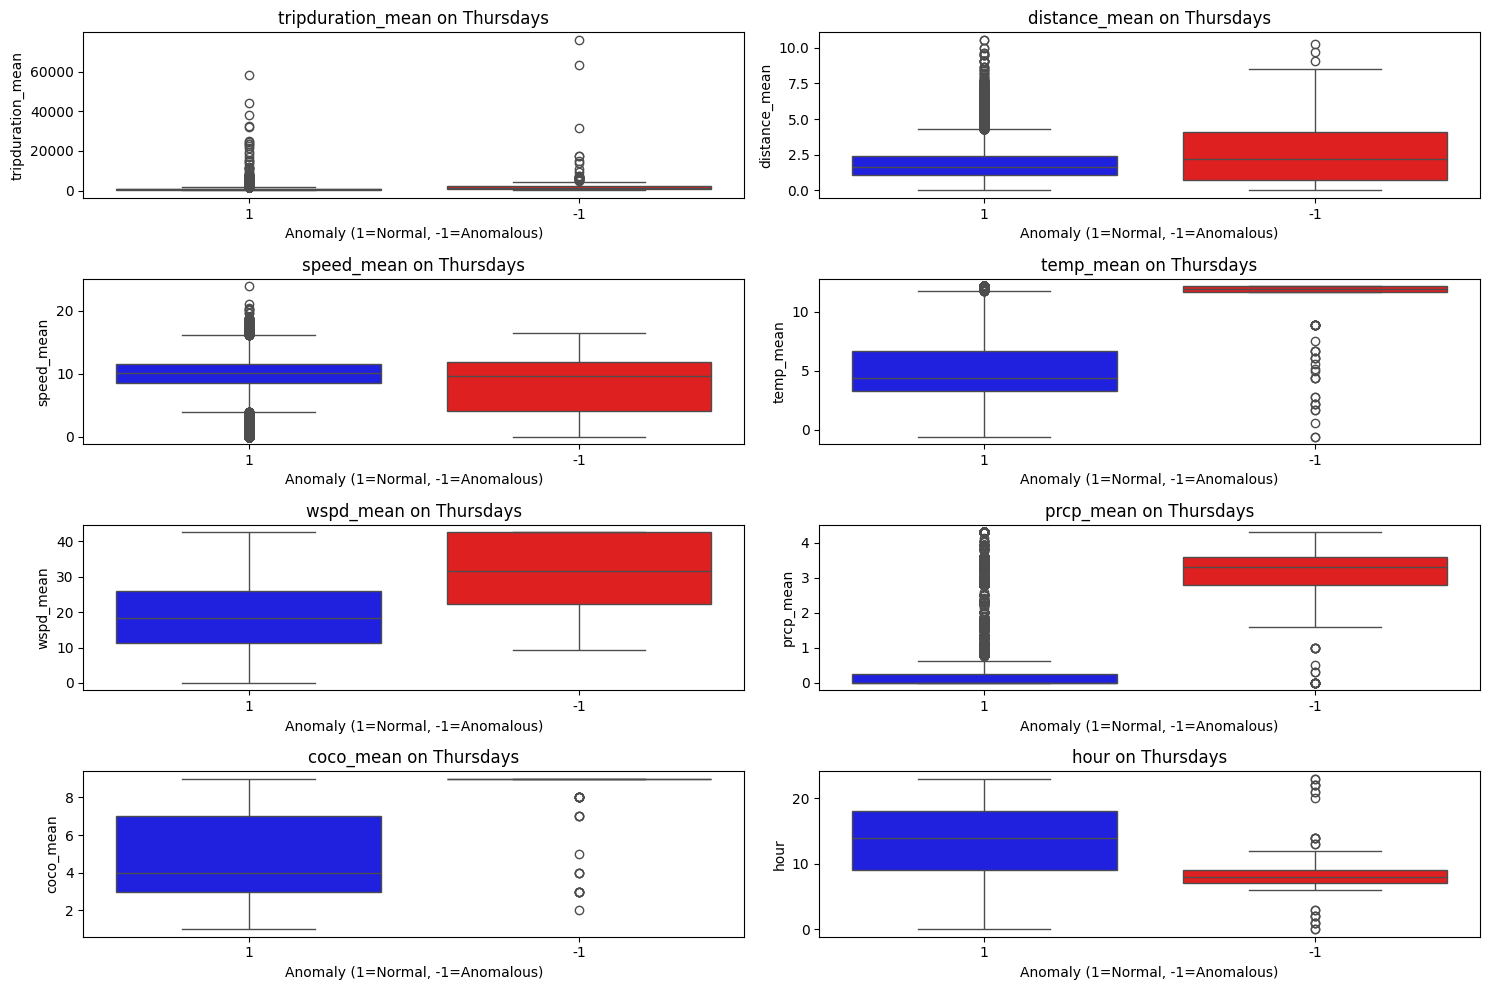

In [33]:
# Step 1: Filter trips for Thursday
station_data_thursday = station_data[(station_data['dayofweek'] == 3)].copy()

# Convert anomaly column to string for visualization
station_data_thursday['anomaly'] = station_data_thursday['anomaly'].astype(str)

# Step 2: Define key numerical features
key_features = [
    'tripduration_mean', 'distance_mean', 'speed_mean',
    'temp_mean', 'wspd_mean', 'prcp_mean', 
    'coco_mean', 'hour'
]

# Step 3: Create box plots for Thursday
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(data=station_data_thursday, x='anomaly', y=feature, palette={"1": "blue", "-1": "red"}, ax=axes[i])
    axes[i].set_title(f"{feature} on Thursdays")
    axes[i].set_xlabel("Anomaly (1=Normal, -1=Anomalous)")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

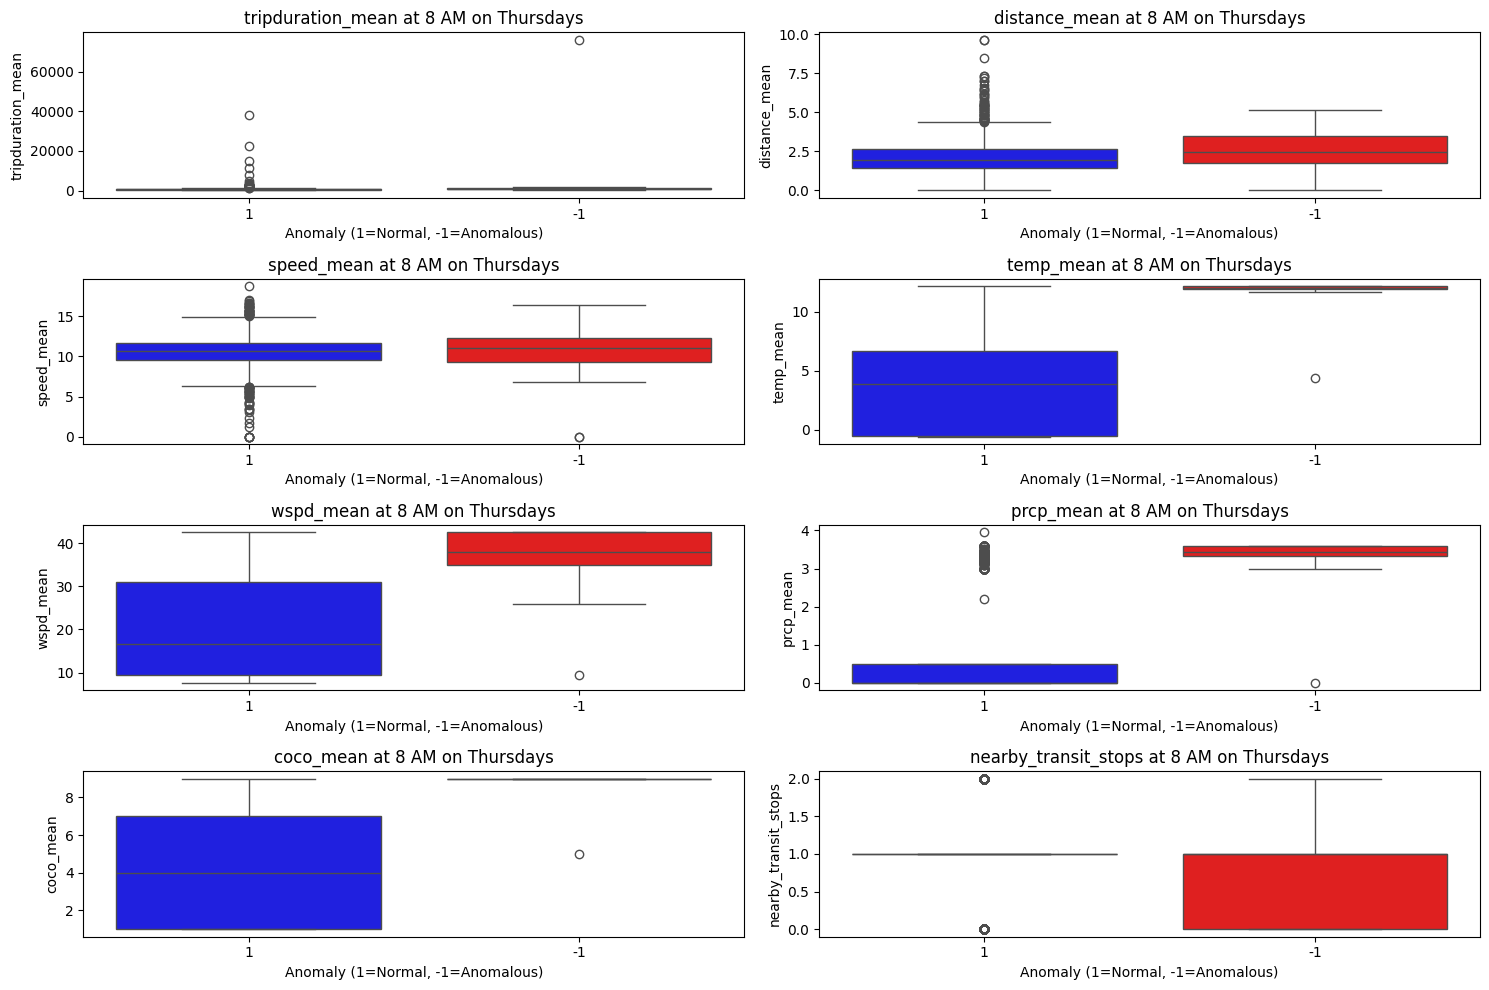

In [35]:
# Step 1: Filter trips for Thursday at 8 AM
thursday_8am_data = station_data[(station_data['hour'] == 8) & (station_data['dayofweek'] == 3)].copy()

# Convert anomaly column to string for visualization
thursday_8am_data['anomaly'] = thursday_8am_data['anomaly'].astype(str)

# Step 2: Define key numerical features
key_features = ['tripduration_mean', 'distance_mean', 'speed_mean', 
                'temp_mean', 'wspd_mean', 'prcp_mean', 'coco_mean', 'nearby_transit_stops']

# Step 3: Create box plots for Thursday at 8 AM
fig, axes = plt.subplots(4, 2, figsize=(15, 10))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    sns.boxplot(data=thursday_8am_data, x='anomaly', y=feature, palette={"1": "blue", "-1": "red"}, ax=axes[i])
    axes[i].set_title(f"{feature} at 8 AM on Thursdays")
    axes[i].set_xlabel("Anomaly (1=Normal, -1=Anomalous)")
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [36]:
# Count anomalies per station for Thursday at 8 AM
thursday_8am_anomalies = thursday_8am_data[(thursday_8am_data['anomaly'] == '-1')]

special_day_anomaly_counts = thursday_8am_anomalies['special_day'].value_counts()
print(special_day_anomaly_counts)


Series([], Name: count, dtype: int64)


In [37]:
# Get station-wise anomaly counts
station_anomaly_counts = thursday_8am_anomalies['station_name'].value_counts()

# Display the top 10 stations with the most anomalies
print(station_anomaly_counts.head(10))


station_name
Nashua Street at Red Auerbach Way                     2
Nichols Ave. at Watertown Greenway                    2
Cambridge St - at Columbia St / Webster Ave           2
Charles Circle - Charles St at Cambridge St           2
Commonwealth Ave at Kelton St                         1
The Eddy - New St at Sumner St                        1
Cambridge Dept. of Public Works -147 Hampshire St.    1
Assembly Square T                                     1
Ames St at Broadway                                   1
Main St at Thompson Sq                                1
Name: count, dtype: int64


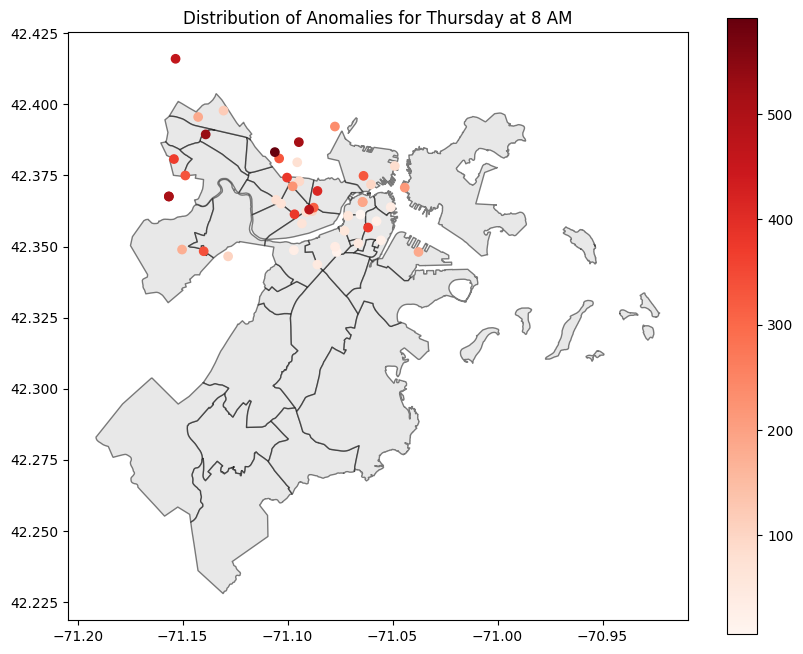

In [39]:
# Spatial visualization
neighborhoods = gpd.read_file('../data/neighborhood_data/boston_cambridge_neighborhoods.geojson')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot neighborhoods for context
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

gdf = gpd.GeoDataFrame(thursday_8am_anomalies, geometry='geometry')
gdf.plot(ax=ax, column='station_id', cmap='Reds', legend=True)
plt.title('Distribution of Anomalies for Thursday at 8 AM')
plt.show()


Observations:
Weather conditions (wind speed, precipitation, temperature) are much worse for anomalies at 8 AM on Thursdays.
Nearby transit stops are significantly lower for anomalies at this time, suggesting a lack of public transport.
Thursdays are not holidays, so we ruled out public holidays as a cause.
We don’t have explicit strike or event data, but the sharp pattern at a fixed time (8 AM) suggests a regular issue rather than a one-time event.

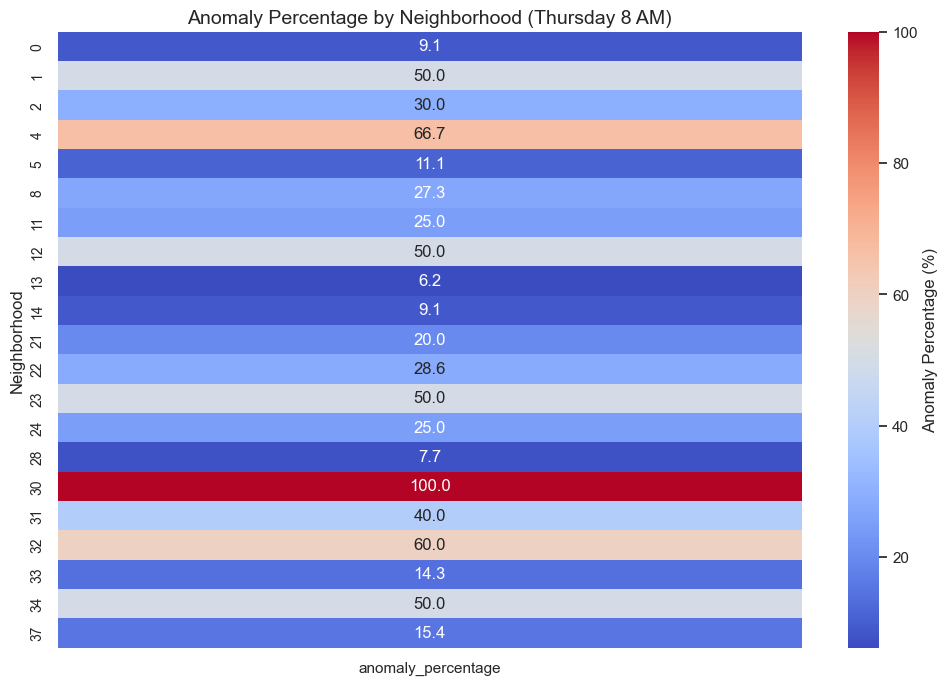

In [64]:
# Step 1: Calculate total stations per neighborhood (using only Thursday 8 AM data)
total_stations_per_neighborhood = thursday_8am_data.groupby('neighborhood')['station_id'].nunique()

# Step 2: Group by 'neighborhood' and count stations with anomalies
grouped_data = thursday_8am_data[thursday_8am_data['anomaly'] == '-1'].groupby('neighborhood').agg(
    stations_with_anomalies=('station_id', 'nunique')  # Count unique stations with anomalies
).reset_index()

# Step 3: Add the total number of stations for each neighborhood
grouped_data['total_stations'] = grouped_data['neighborhood'].map(total_stations_per_neighborhood)

# Step 4: Calculate the anomaly percentage (percentage of stations with anomalies)
grouped_data['anomaly_percentage'] = (grouped_data['stations_with_anomalies'] / grouped_data['total_stations']) * 100

# Step 5: Pivot the grouped data for heatmap visualization
pivot_table_percentage = grouped_data.pivot_table(
    values='anomaly_percentage',
    index='neighborhood',
    fill_value=0
)

# Step 6: Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table_percentage, cmap='coolwarm', cbar_kws={'label': 'Anomaly Percentage (%)'}, annot=True, fmt=".1f")

# Improved title and labels
plt.title('Anomaly Percentage by Neighborhood (Thursday 8 AM)', fontsize=14)
plt.ylabel('Neighborhood', fontsize=12)
plt.yticks(fontsize=10)

plt.show()

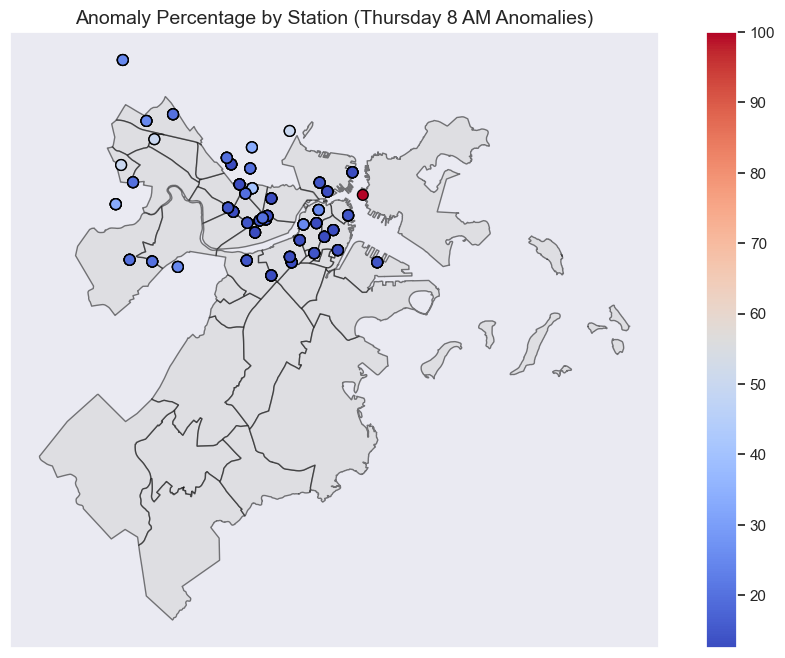

In [72]:
# Load neighborhood shapes
neighborhoods = gpd.read_file('../data/neighborhood_data/boston_cambridge_neighborhoods.geojson')

#  Calculate anomaly percentage for each station
station_total_counts = thursday_8am_data.groupby('station_id').size()
station_anomaly_counts = thursday_8am_data[thursday_8am_data['anomaly'] == '-1'].groupby('station_id').size()

# Ensure missing values are handled correctly and filter out 0% anomalies
station_anomaly_percentage = (station_anomaly_counts / station_total_counts * 100).fillna(0)
station_anomaly_percentage = station_anomaly_percentage[station_anomaly_percentage > 0]  # Remove 0% anomalies

#  Merge anomaly percentages back to GeoDataFrame (only keep stations with anomalies)
thursday_8am_data['anomaly_percentage'] = thursday_8am_data['station_id'].map(station_anomaly_percentage)

# Filter only stations with anomalies
gdf = gpd.GeoDataFrame(thursday_8am_data.dropna(subset=['geometry', 'anomaly_percentage']), geometry='geometry')

#  Plot the heatmap on the map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot neighborhoods for context
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

# Plot stations with color-coded anomaly percentage (filtered for >0%)
gdf.plot(ax=ax, column='anomaly_percentage', cmap='coolwarm', legend=True, markersize=60, edgecolor='black')

# Improve title and styling
plt.title('Anomaly Percentage by Station (Thursday 8 AM Anomalies)', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])

plt.show()

### Local Diffi interpretation of the spikes

We would like to check if our observations with box plots and Local Diffi interpretation are similar

In [50]:
features = [
    'count',                 # Core usage metric
    'distance_mean',         # Average trip distance
    'tripduration_mean',     # Average trip duration
    'speed_mean',            # Average trip speed
    'temp_mean',             # Weather impact
    'prcp_mean',             # Weather impact
    'wspd_mean',             # Weather impact
    'hour',                  # Temporal variation
    'day',
    'dayofweek',             # Temporal variation
    'nearby_transit_stops',   # Station context
    'user_type_encoded_mean',
    'coco_mean',             
    'is_weekend',
    'neighborhood',
    'is_start'
]
X = thursday_8am_data[features].fillna(0)


In [51]:
iforest = IsolationForest(n_estimators= 500, max_samples=1024, contamination='auto', random_state=0)
iforest.fit(X)
y_pred = np.array(iforest.decision_function(X) < 0).astype('int')


In [52]:
sorted_idx = diffi_ranks(X, n_trees=100, max_samples=1024, n_iter=5)
sorted_feature_names = X.columns[sorted_idx].tolist()

In [56]:
X.columns[sorted_idx]

Index(['tripduration_mean', 'speed_mean', 'user_type_encoded_mean',
       'distance_mean', 'count', 'temp_mean', 'prcp_mean', 'neighborhood',
       'wspd_mean', 'is_start', 'coco_mean', 'nearby_transit_stops', 'day',
       'is_weekend', 'dayofweek', 'hour'],
      dtype='object')

In [54]:
# Local-DIFFI
diffi_te, ord_idx_diffi_te, exec_time_diffi_te = local_diffi_batch(iforest, X.iloc[y_pred == 1])
print('Average computational time Local-DIFFI: {}'.format(round(np.mean(exec_time_diffi_te),3)))

Average computational time Local-DIFFI: 0.289


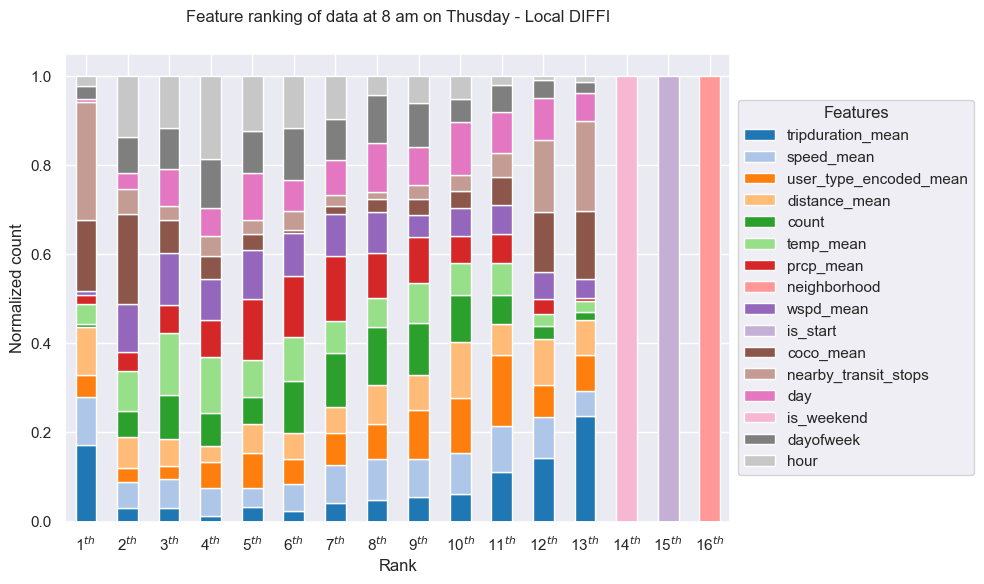

In [55]:
plot_feature_ranking(ord_idx_diffi_te, title = 'Feature ranking of data at 8 am on Thusday - Local DIFFI', sorted_feature_names = sorted_feature_names)

Here we see that Local DIFFI results confirm our findings!

- `nearby_transit_stops` appears in the top ranks, which is rare in general cases.
- `Weather-related` features are also among the top-ranked.
- `tripduration_mean`, `distance_mean`, and `speed_mean` remain important, reinforcing that anomalies are linked to unusual travel patterns.

## Trends

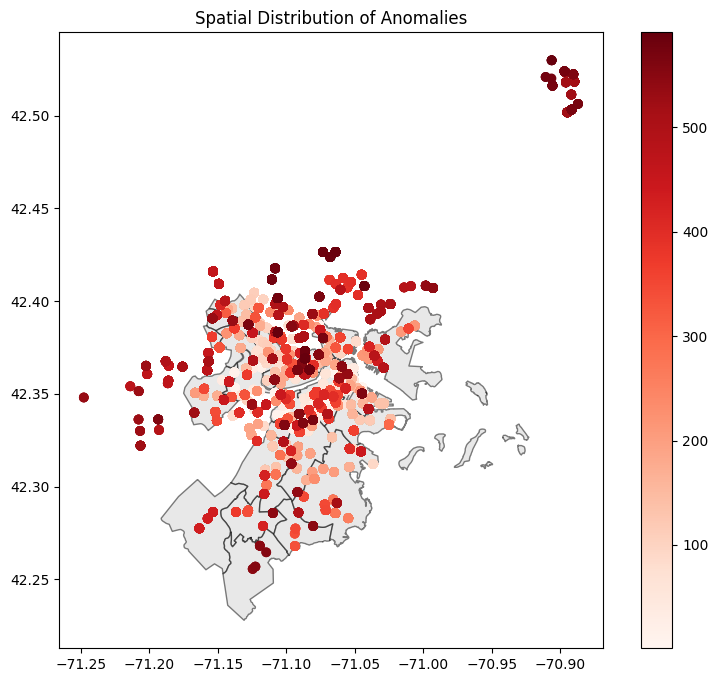

In [7]:
# Spatial visualization
neighborhoods = gpd.read_file('../data/neighborhood_data/boston_cambridge_neighborhoods.geojson')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot neighborhoods for context
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

gdf = gpd.GeoDataFrame(station_data, geometry='geometry')
anomalies = gdf[gdf['anomaly'] == 1]
anomalies.plot(ax=ax, column='station_id', cmap='Reds', legend=True)
plt.title('Spatial Distribution of Anomalies')
plt.show()


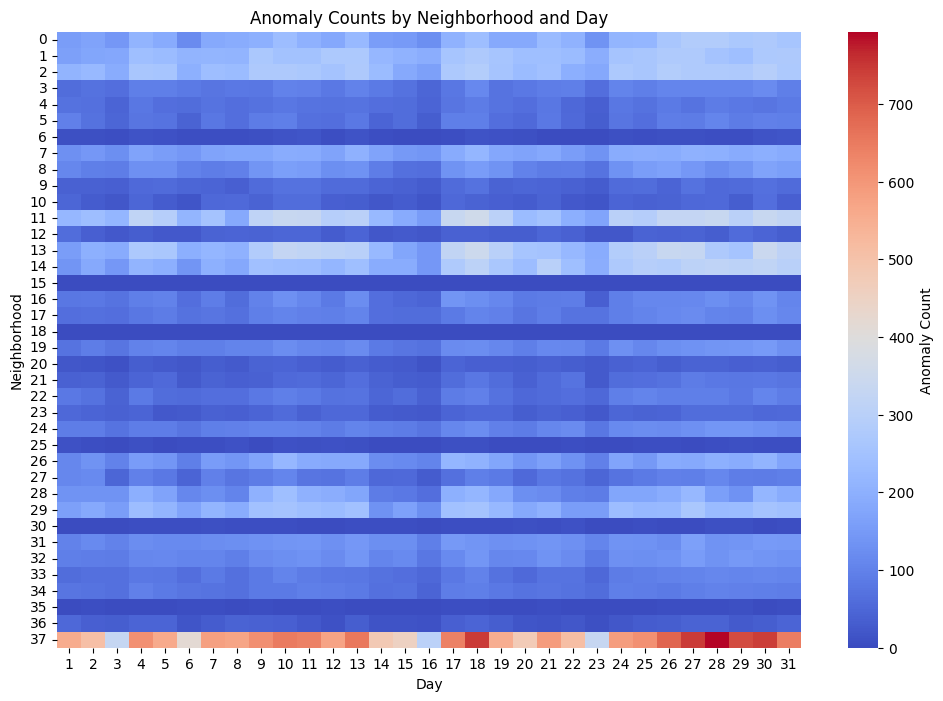

In [13]:
# Group by 'neighborhood' instead of individual 'station_id'
station_data['neighborhood'] = station_data['neighborhood'].fillna('Unknown')  # Handle missing values
grouped_data = station_data.groupby(['neighborhood', 'day']).agg(
    anomaly_rate=('anomaly', 'mean'),
    total_count=('anomaly', 'size')
).reset_index()

# Pivot the grouped data for heatmap
pivot_table = grouped_data.pivot_table(
    values='total_count',
    index='neighborhood',
    columns='day',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size for readability
sns.heatmap(pivot_table, cmap='coolwarm', cbar_kws={'label': 'Anomaly Count'})
plt.title('Anomaly Counts by Neighborhood and Day')
plt.xlabel('Day')
plt.ylabel('Neighborhood')
plt.show()


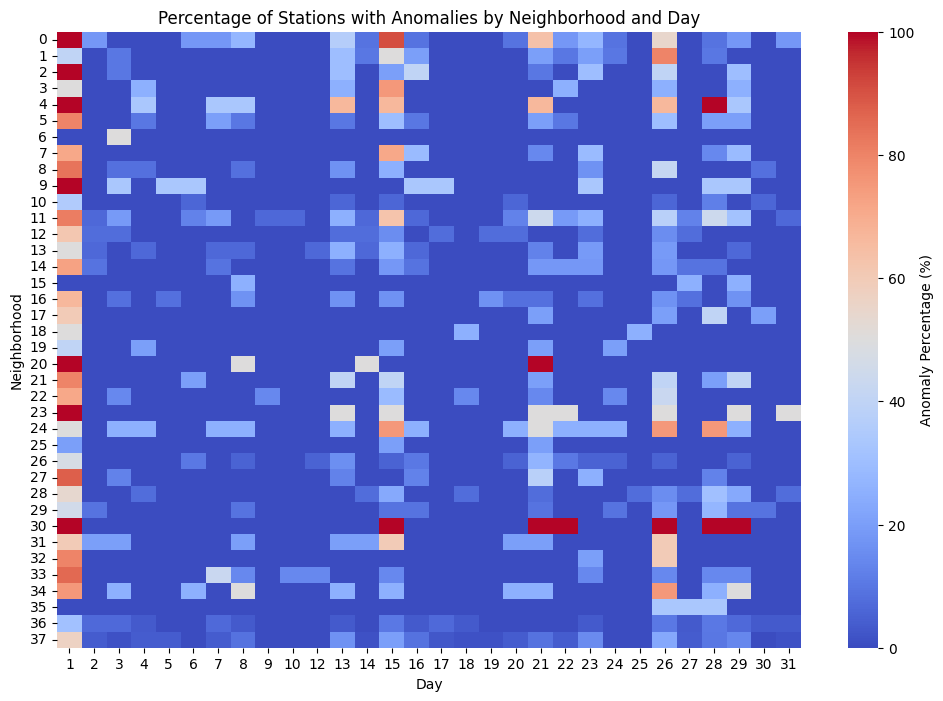

In [20]:
# Calculate total stations per neighborhood
total_stations_per_neighborhood = station_data.groupby('neighborhood')['station_id'].nunique()

# Group by 'neighborhood' and 'day' to count stations with anomalies
grouped_data = station_data[station_data['anomaly'] < 0].groupby(['neighborhood', 'day']).agg(
    stations_with_anomalies=('station_id', 'nunique')  # Count unique stations with anomalies
).reset_index()

# Add the total number of stations for each neighborhood
grouped_data['total_stations'] = grouped_data['neighborhood'].map(total_stations_per_neighborhood)

# Calculate the anomaly percentage (percentage of stations with anomalies)
grouped_data['anomaly_percentage'] = (grouped_data['stations_with_anomalies'] / grouped_data['total_stations']) * 100

# Pivot the grouped data for the heatmap
pivot_table_percentage = grouped_data.pivot_table(
    values='anomaly_percentage',
    index='neighborhood',
    columns='day',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size for readability
sns.heatmap(pivot_table_percentage, cmap='coolwarm', cbar_kws={'label': 'Anomaly Percentage (%)'})
plt.title('Percentage of Stations with Anomalies by Neighborhood and Day')
plt.xlabel('Day')
plt.ylabel('Neighborhood')
plt.show()


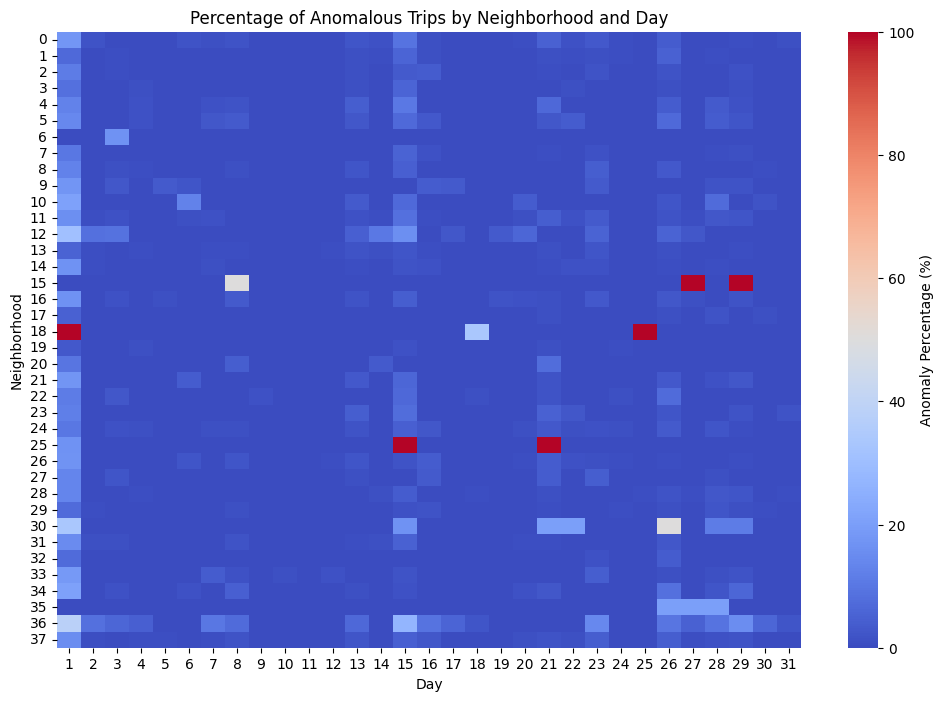

In [31]:
# Group by 'neighborhood' and 'day' to calculate total trips and anomalous trips
grouped_data = station_data.groupby(['neighborhood', 'day']).agg(
    total_trips=('anomaly', 'size'),            # Total number of trips (count rows)
    anomalous_trips=('anomaly', lambda x: (x == -1).sum())  # Count trips flagged as anomalies
).reset_index()

# Calculate the anomaly percentage (percentage of anomalous trips)
grouped_data['anomaly_percentage'] = (grouped_data['anomalous_trips'] / grouped_data['total_trips']) * 100

# Pivot the grouped data for the heatmap
pivot_table_percentage = grouped_data.pivot_table(
    values='anomaly_percentage',
    index='neighborhood',
    columns='day',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust size for readability
sns.heatmap(pivot_table_percentage, cmap='coolwarm', cbar_kws={'label': 'Anomaly Percentage (%)'})
plt.title('Percentage of Anomalous Trips by Neighborhood and Day')
plt.xlabel('Day')
plt.ylabel('Neighborhood')
plt.show()


In [34]:
def analyze_neighborhood_day(station_data, neighborhood, day):

    # Filter data for the given neighborhood and day
    filtered_data = station_data[(station_data['neighborhood'] == neighborhood) & 
                                 (station_data['day'] == day)]
    
    if filtered_data.empty:
        print(f"No data found for neighborhood '{neighborhood}' on day {day}.")
        return None

    # Calculate basic statistics
    total_stations = filtered_data['station_id'].nunique()
    anomalies = filtered_data[filtered_data['anomaly'] == -1]
    anomaly_count = anomalies['station_id'].nunique()

    print(f"--- Analysis for Neighborhood: {neighborhood}, Day: {day} ---")
    print(f"Total stations in the neighborhood: {total_stations}")
    print(f"Stations with anomalies: {anomaly_count} ({(anomaly_count / total_stations) * 100:.2f}%)")
    print("\nDetails of Stations with Anomalies:")
    print(anomalies) 

    # Return filtered data for further analysis if needed
    return anomalies


In [35]:
neighborhood_to_analyze = 15
day_to_analyze = 29

anomalous_data = analyze_neighborhood_day(station_data, neighborhood_to_analyze, day_to_analyze)

--- Analysis for Neighborhood: 15, Day: 29 ---
Total stations in the neighborhood: 1
Stations with anomalies: 1 (100.00%)

Details of Stations with Anomalies:
        station_id  hour  day  month  is_start  count  tripduration_mean  \
126748         548     3   29      1         0      1             3379.0   

        tripduration_std  tripduration_median  distance_mean  ...  wspd_mean  \
126748               0.0               3379.0       9.973858  ...       14.8   

        coco_mean          station_name  neighborhood  \
126748        3.0  555 Metropolitan Ave            15   

                         geometry  nearby_transit_stops  dayofweek  \
126748  POINT (-71.11924 42.2681)                     1          6   

        is_weekend  special_day  anomaly  
126748           1         None       -1  

[1 rows x 28 columns]


In [49]:
# Function to get stations by neighborhood
def get_stations_in_neighborhood(neighborhood_number):
    neighborhoods = station_data['neighborhood'].unique()
        
    # Retrieve the stations in that neighborhood
    stations = station_data[station_data['neighborhood'] == neighborhood_number]['station_id'].unique()
    return stations

neighborhood_number = 37
stations = get_stations_in_neighborhood(neighborhood_number)

print(f"Neighborhood: {neighborhood_number}")
print(f"Stations: {', '.join(map(str, stations))}")


Neighborhood: 37
Stations: 69, 71, 77, 78, 82, 86, 99, 100, 102, 103, 111, 114, 137, 187, 188, 191, 193, 194, 226, 233, 234, 235, 236, 239, 328, 330, 377, 378, 387, 389, 390, 391, 393, 394, 395, 396, 397, 401, 402, 403, 408, 452, 455, 458, 461, 462, 466, 469, 475, 480, 482, 484, 485, 487, 494, 495, 496, 497, 498, 499, 502, 503, 504, 505, 506, 507, 508, 509, 514, 523, 530, 531, 540, 541, 550, 565, 576, 578, 591


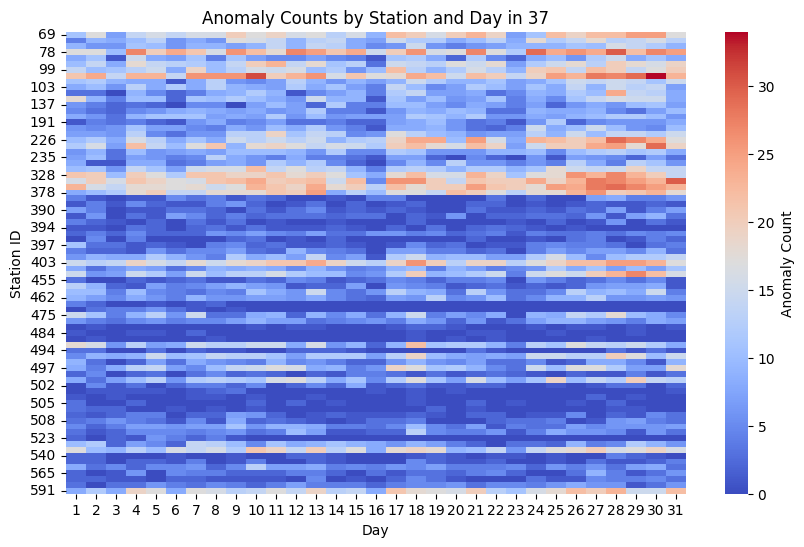

In [41]:
all_days = np.arange(1, 32)  # Assuming 1 to 31 days
all_combinations = pd.MultiIndex.from_product(
    [stations, all_days],
    names=['station_id', 'day']
).to_frame(index=False)

daywise_summary = station_data.groupby(['station_id', 'day']).agg(
    anomaly_rate=('anomaly', 'mean'),
    total_count=('anomaly', 'size')
).reset_index()

# Merge with daywise_summary to ensure all days are included
complete_daywise_summary = all_combinations.merge(
    daywise_summary,
    on=['station_id', 'day'],
    how='left'
).fillna({'anomaly_rate': 0, 'total_count': 0})

# Pivot data for the heatmap
pivot_table = complete_daywise_summary.pivot_table(
    values='total_count',
    index='station_id',
    columns='day',
    fill_value=0
)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='coolwarm', cbar_kws={'label': 'Anomaly Count'})
plt.title(f'Anomaly Counts by Station and Day in {neighborhood_number}')
plt.xlabel('Day')
plt.ylabel('Station ID')
plt.show()

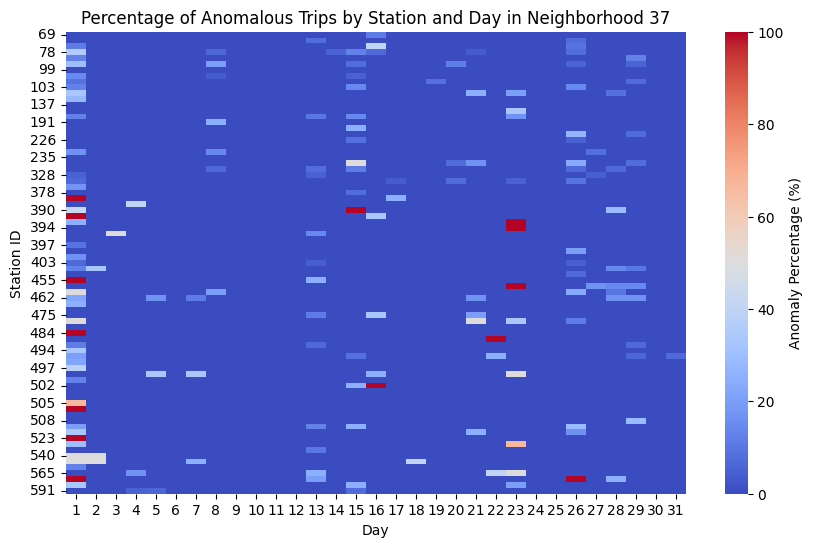

   station_id  day  total_trips  anomalous_trips  anomaly_percentage
0          69    1         11.0              0.0                 0.0
1          69    2         17.0              0.0                 0.0
2          69    3          7.0              0.0                 0.0
3          69    4         14.0              0.0                 0.0
4          69    5         16.0              0.0                 0.0


In [40]:
# Filter data for the given neighborhood
neighborhood_number = 37  # Replace with the desired neighborhood number
neighborhood_data = station_data[station_data['neighborhood'] == neighborhood_number]

if neighborhood_data.empty:
    print(f"No data found for neighborhood {neighborhood_number}.")
else:
    # Get all unique stations in the neighborhood
    stations = neighborhood_data['station_id'].unique()

    # Create a full combination of stations and days
    all_days = np.arange(1, 32)  # Assuming 1 to 31 days
    all_combinations = pd.MultiIndex.from_product(
        [stations, all_days],
        names=['station_id', 'day']
    ).to_frame(index=False)

    # Group by station and day to calculate total trips and anomalous trips
    daywise_summary = neighborhood_data.groupby(['station_id', 'day']).agg(
        total_trips=('anomaly', 'size'),  # Total trips (count rows)
        anomalous_trips=('anomaly', lambda x: (x == -1).sum())  # Count anomalous trips
    ).reset_index()

    # Merge to ensure all combinations of stations and days are included
    complete_daywise_summary = all_combinations.merge(
        daywise_summary,
        on=['station_id', 'day'],
        how='left'
    ).fillna({'total_trips': 0, 'anomalous_trips': 0})

    # Calculate the anomaly percentage
    complete_daywise_summary['anomaly_percentage'] = (
        complete_daywise_summary['anomalous_trips'] / complete_daywise_summary['total_trips']
    ) * 100
    complete_daywise_summary['anomaly_percentage'] = complete_daywise_summary['anomaly_percentage'].fillna(0)

    # Pivot data for the heatmap
    pivot_table = complete_daywise_summary.pivot_table(
        values='anomaly_percentage',
        index='station_id',
        columns='day',
        fill_value=0
    )

    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, cmap='coolwarm', cbar_kws={'label': 'Anomaly Percentage (%)'})
    plt.title(f'Percentage of Anomalous Trips by Station and Day in Neighborhood {neighborhood_number}')
    plt.xlabel('Day')
    plt.ylabel('Station ID')
    plt.show()

    # Print summary (optional)
    print(complete_daywise_summary.head())


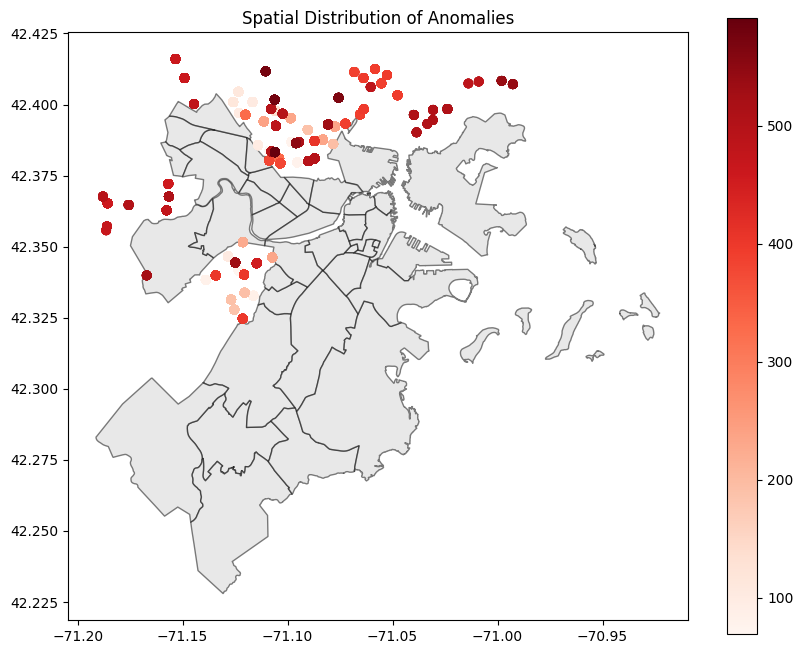

In [58]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot neighborhoods for context
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

gdf = gpd.GeoDataFrame(station_data[station_data['station_id'].isin(stations)], geometry='geometry')
anomalies = gdf[gdf['anomaly'] == 1]
anomalies.plot(ax=ax, column='station_id', cmap='Reds', legend=True)
plt.title('Spatial Distribution of Anomalies')
plt.show()


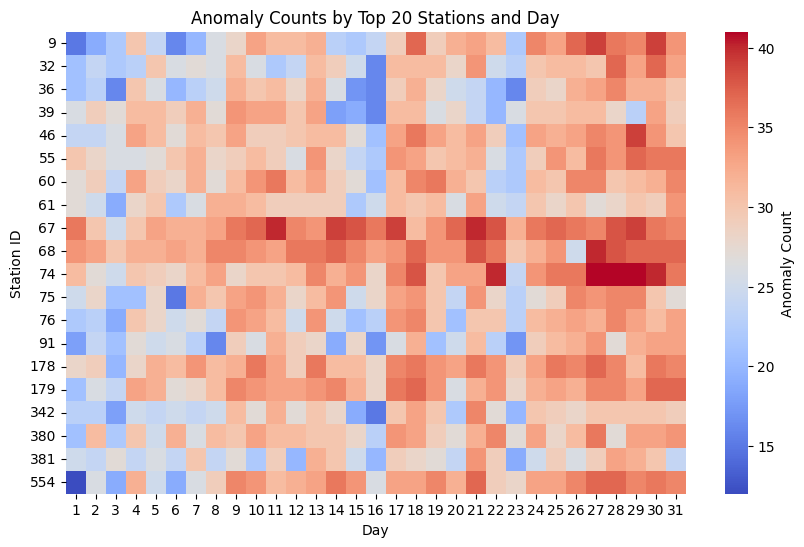

In [6]:
# Calculate the total number of anomalies per station
station_anomaly_counts = station_data.groupby('station_id')['anomaly'].sum().sort_values(ascending=False)

# Select the top 20 stations with the most anomalies
top_stations = station_anomaly_counts.head(20).index

# Filter data for these stations
sampled_data = station_data[station_data['station_id'].isin(top_stations)]

# Aggregate and create the heatmap
daywise_summary = sampled_data.groupby(['station_id', 'day']).agg(
    anomaly_rate=('anomaly', 'mean'),
    total_count=('anomaly', 'size')
).reset_index()

pivot_table = daywise_summary.pivot_table(
    values='total_count',
    index='station_id',
    columns='day',
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='coolwarm', cbar_kws={'label': 'Anomaly Count'})
plt.title('Anomaly Counts by Top 20 Stations and Day')
plt.xlabel('Day')
plt.ylabel('Station ID')
plt.show()


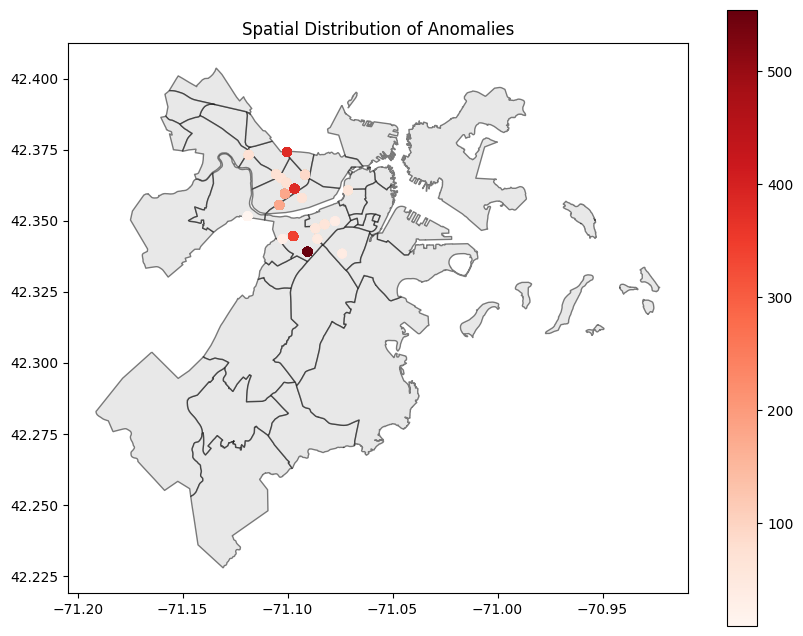

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot neighborhoods for context
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

gdf = gpd.GeoDataFrame(sampled_data, geometry='geometry')
anomalies = gdf[gdf['anomaly'] == 1]
anomalies.plot(ax=ax, column='station_id', cmap='Reds', legend=True)
plt.title('Spatial Distribution of Anomalies')
plt.show()


## Self-trips

In [3]:
leisure_trips = station_data[station_data['distance_mean'] == 0]

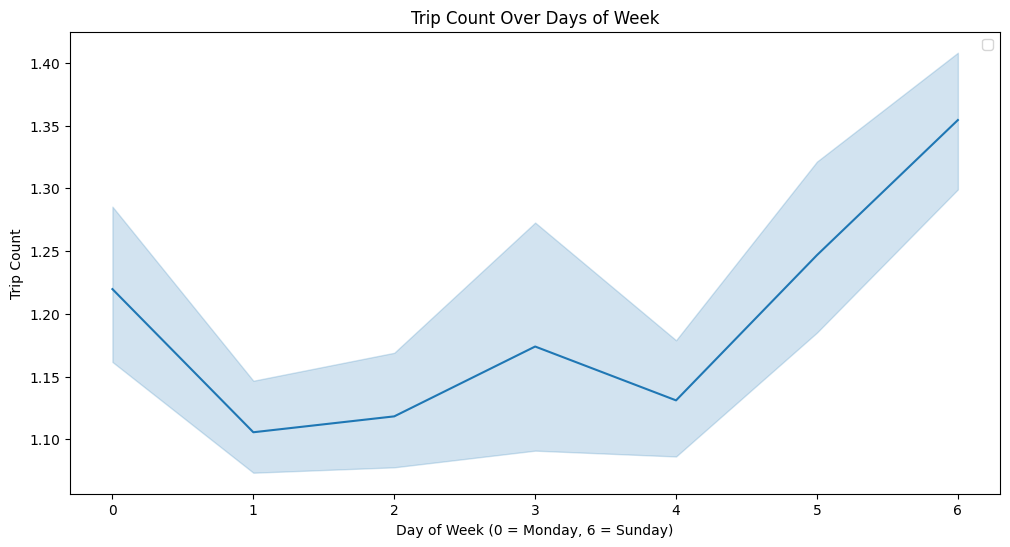

In [7]:
# Temporal Line Plot by Day of Week
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=leisure_trips, x='dayofweek', y='count')
plt.title('Trip Count Over Days of Week')
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Trip Count')
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles=handles)
plt.show()

In [13]:
station_counts = leisure_trips['station_name'].value_counts().head(10)
station_counts

station_name
Discovery Park - 30 Acorn Park Drive            42
Rindge Avenue - O'Neill Library                 40
Murphy Skating Rink - 1880 Day Blvd             31
Porzio Park                                     29
Railroad Lot and Minuteman Bikeway              29
Government Center - Cambridge St at Court St    26
Cleveland Circle                                26
Powder House Circle - Nathan Tufts Park         24
Commonwealth Ave At Babcock St                  23
Maverick Square - Lewis Mall                    22
Name: count, dtype: int64

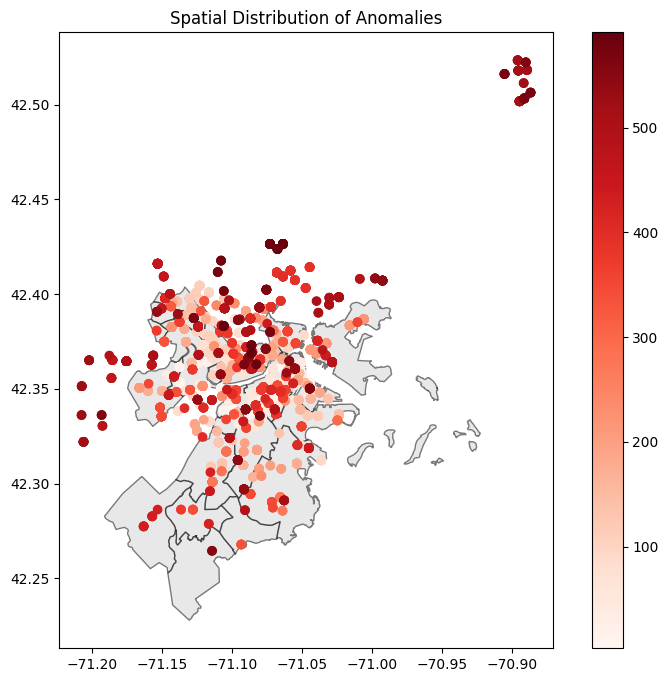

In [15]:
# Spatial visualization
neighborhoods = gpd.read_file('../data/neighborhood_data/boston_cambridge_neighborhoods.geojson')
fig, ax = plt.subplots(figsize=(10, 8))

# Plot neighborhoods for context
neighborhoods.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)

gdf = gpd.GeoDataFrame(leisure_trips, geometry='geometry')
# anomalies = gdf[gdf['anomaly'] == 1]
gdf.plot(ax=ax, column='station_id', cmap='Reds', legend=True)
plt.title('Spatial Distribution of Anomalies')
plt.show()
